In [1]:
# imports

import os
import random
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
from items import Item
from loaders import ItemLoader
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import numpy as np
import pickle
from tqdm import tqdm
from testing import Tester

In [2]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [3]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [4]:
dataset_names = ["Video_Games"]
items = []
for dataset_name in dataset_names:
    loader = ItemLoader(dataset_name)
    items.extend(loader.load())

Loading dataset Video_Games


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:39<00:00,  3.46it/s]


Completed Video_Games with 51,041 datapoints in 0.7 mins


In [5]:
print(f"A grand total of {len(items):,} items")

A grand total of 51,041 items


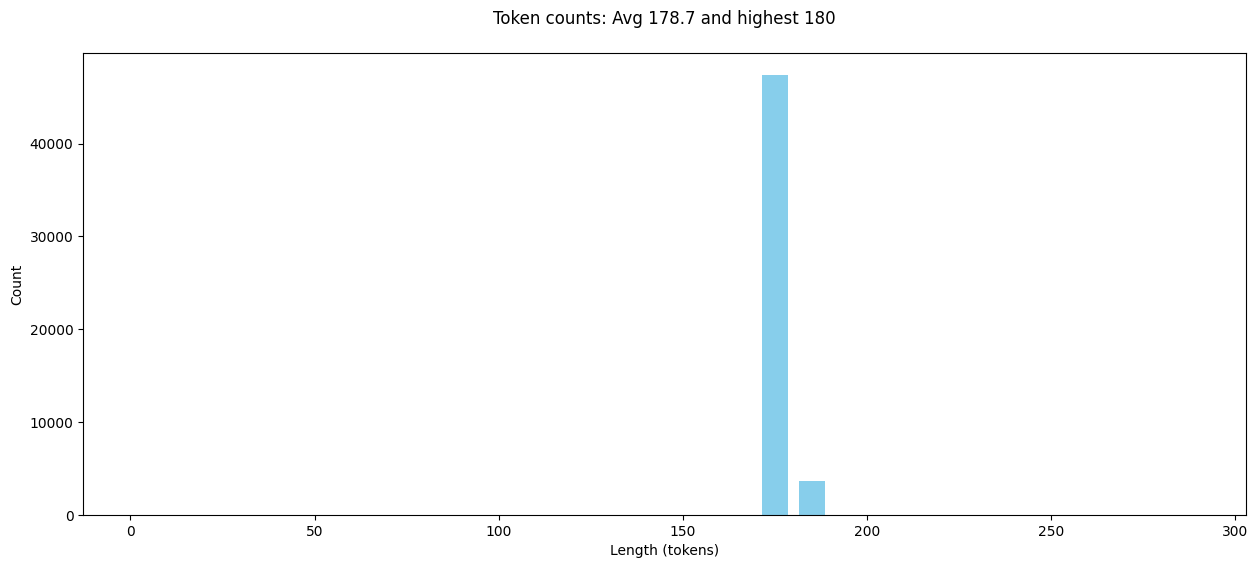

In [6]:
# Plot the distribution of token counts again

tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="skyblue", bins=range(0, 300, 10))
plt.show()

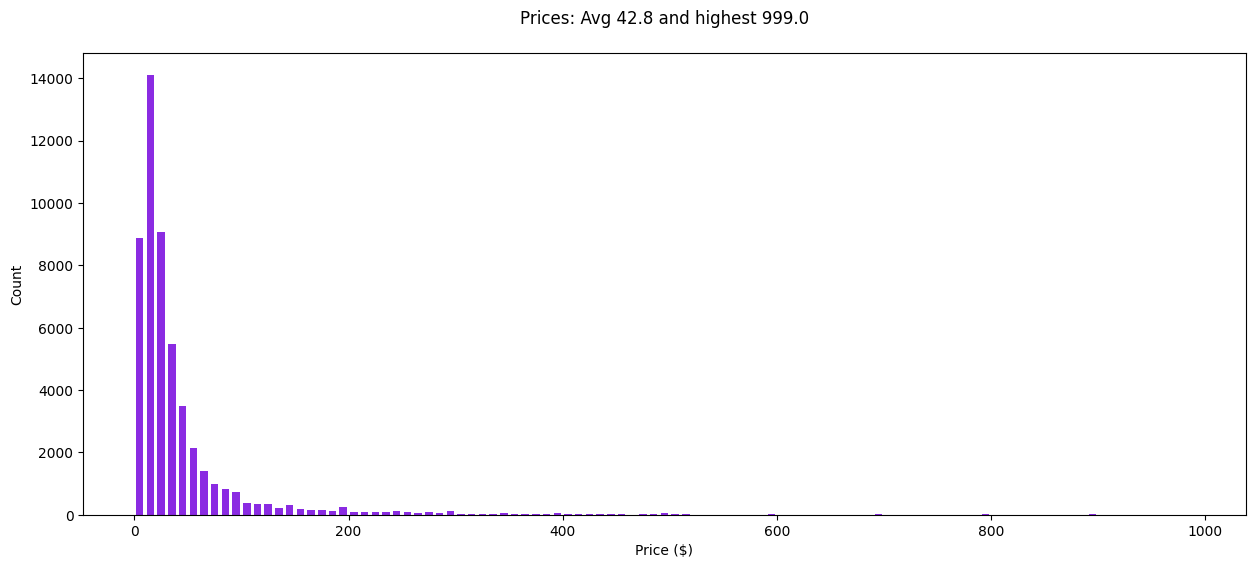

In [7]:
# Plot the distribution of prices

prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="blueviolet", bins=range(0, 1000, 10))
plt.show()

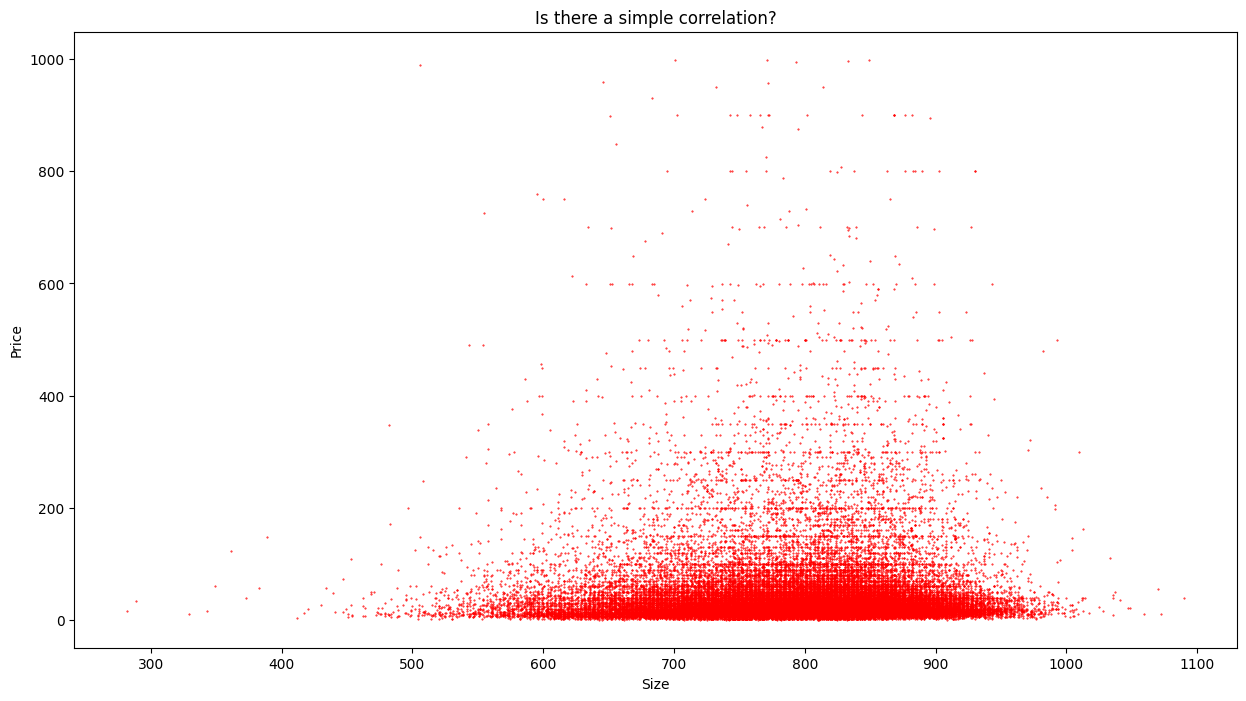

In [8]:
# How does the price vary with the character count of the prompt?

sample = items

sizes = [len(item.prompt) for item in sample]
prices = [item.price for item in sample]

# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(sizes, prices, s=0.2, color="red")

# Add labels and title
plt.xlabel('Size')
plt.ylabel('Price')
plt.title('Is there a simple correlation?')

# Display the plot
plt.show()

In [9]:
def report(item):
    prompt = item.prompt
    tokens = Item.tokenizer.encode(item.prompt)
    print(prompt)
    print(tokens[-10:])
    print(Item.tokenizer.batch_decode(tokens[-10:]))

report(sample[50])

How much does this cost to the nearest dollar?

IEason,Vintage Classic Men's Waterproof Date Leather Strap Sport Quartz Army Watch (Light Green)
❤Gender Men,boys☛watches for men men watches men watches on sale men watches on sale clearance luxury men watches on sale clearance waterproof men watches leather band men watches leather guess men watches leather strap men watches gold stainless men watches fossil ❤Movement Quartz ❤Watchcase Diameter 4.2cm approx. ❤Package Content 1x watch ❤Quartz Watches Jewelry Watches Sport Wristwatch Luxury Watches Casual quartz watch CasualWatch Women Wristwatch Rose Field Watch Charm Simple Wristwatch Fashion Jewelry Gifts Analog Watch Vintage Watch Retro quartz watch Vogue Women Fashion Strap Watches Bright Dress Accessories Steel Women Waterproof Bracelet dial Classics Women Watch Stainless Steel Clock Leather Strap Vintage Watches Gold Watch Women Watch LED Watch Digital Watch Simple leather

Price is $8.00
[8993, 17553, 271, 6972, 374, 400, 23, 13, 

In [10]:
random.seed(42)
random.shuffle(sample)
train = sample[:25_000]
test = sample[25_000:27_000]
print(f"Divided into a training set of {len(train):,} items and test set of {len(test):,} items")

Divided into a training set of 25,000 items and test set of 2,000 items


In [11]:
print(train[0].prompt)

How much does this cost to the nearest dollar?

QJYTH Replacement Cord Compatible with Logitech Pro/G Pro X Headset, Inline Mute and Volume Control Audio Cable Wire Compatible with Feet)
Compatibility The replacement cable is compatible with Logitech G433/ G233/ G Pro/ G Pro X gaming headset. NOT FIT OTHER MODELS. High Sound Quality Oxygen-Free Copper wire with gold-plated corrosion resistance connectors, provides optimal signal transmission and delivers clear and crisp audio and endues no-loss, noise-free, high-fidelity audio experience. Enough Length 2 meters black audio cable for G433 headset, perfect to replace the defective cable, saves the cost of replacing headsets. 3.5 mm Gold-Plated Jack A quality and sturdy 3.5mm gold-plated audio jack provides excellent

Price is $12.00


In [12]:
print(test[0].test_prompt())

How much does this cost to the nearest dollar?

Horror Double Feature (Night Train to Terror / The Thirsty Dead)
Night Train To Terror (1985, Color) God and the devil debate the fates of human souls while riding on a hell-bound train. This terrifying anthology of horror stories, patterned after the famous British Amicus productions of the 60s and 70s ( Dr. Terror's House of Horrors, The Vault of Horror, Tales From The Crypt ), features stories penned by award-winning writer Philip Yordan ( Broken Lance, El Cid, King of Kings ). The horrific tales featured here are brimming with blood, gore, nudity and animated special effects. Starring John Philip Law, Cameron Mitchell, Richard Moll, Eva Hesse, Marc Lawrence; Directed by John Carr,

Price is $


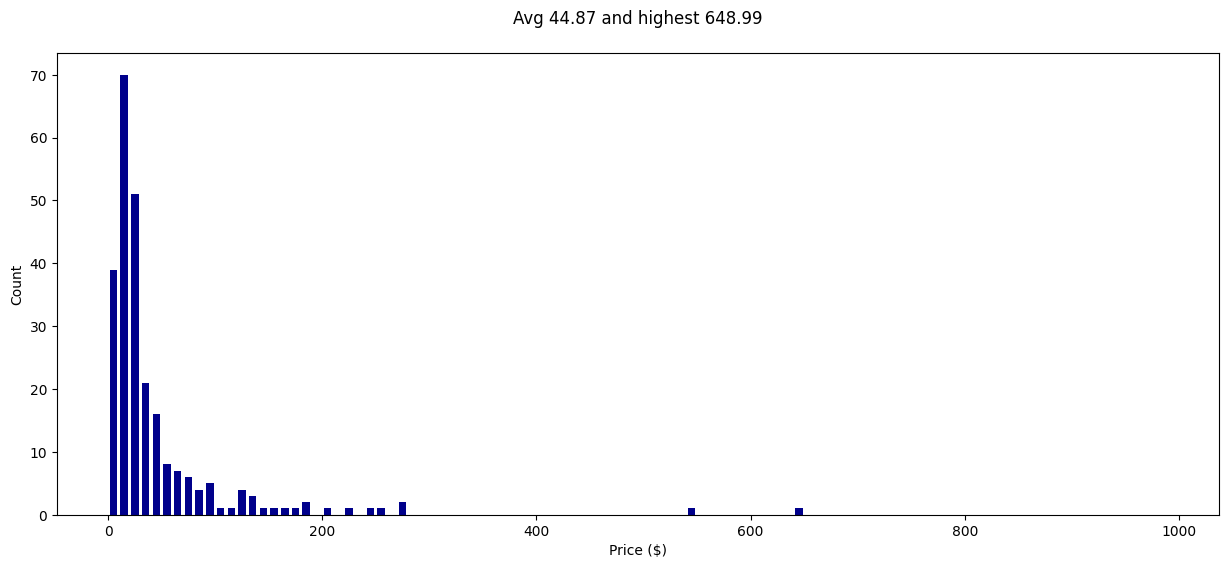

In [13]:
# Plot the distribution of prices in the first 250 test points

prices = [float(item.price) for item in test[:250]]
plt.figure(figsize=(15, 6))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

In [14]:
train_prompts = [item.prompt for item in train]
train_prices = [item.price for item in train]
test_prompts = [item.test_prompt() for item in test]
test_prices = [item.price for item in test]

In [15]:
# Create a Dataset from the lists

train_dataset = Dataset.from_dict({"text": train_prompts, "price": train_prices})
test_dataset = Dataset.from_dict({"text": test_prompts, "price": test_prices})
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

In [19]:
DATASET_NAME = "baihaqiyazid/lite-data"
dataset.push_to_hub(DATASET_NAME, private=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/25 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/412 [00:00<?, ?B/s]

D:\yazid\belajar\llm_engineering\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\yazid.baihaqi\.cache\huggingface\hub\datasets--baihaqiyazid--lite-data. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/datasets/baihaqiyazid/lite-data/commit/0b156363634811a23cd9a3e1c4c06c8088a82d94', commit_message='Upload dataset', commit_description='', oid='0b156363634811a23cd9a3e1c4c06c8088a82d94', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/baihaqiyazid/lite-data', endpoint='https://huggingface.co', repo_type='dataset', repo_id='baihaqiyazid/lite-data'), pr_revision=None, pr_num=None)

In [20]:
# One more thing!
# Let's pickle the training and test dataset so we don't have to execute all this code next time!

with open('train_lite.pkl', 'wb') as file:
    pickle.dump(train, file)

with open('test_lite.pkl', 'wb') as file:
    pickle.dump(test, file)

# Visualize

In [16]:
import chromadb
from sklearn.manifold import TSNE
import plotly.graph_objects as go
from sentence_transformers import SentenceTransformer

In [17]:
DB = "products_video_games_vectorstore"

client = chromadb.PersistentClient(path=DB)

collection_name = "products"
# existing_collection_names = [collection.name for collection in client.list_collections()]
# if collection_name in existing_collection_names:
#     client.delete_collection(collection_name)
#     print(f"Deleted existing collection: {collection_name}")

collection = client.get_collection(collection_name)

In [25]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
model.encode(["Well hi there"])

array([[-9.46715847e-02,  4.27620150e-02,  5.51621132e-02,
        -5.10936254e-04,  1.16203148e-02, -6.80130273e-02,
         2.76406072e-02,  6.06974177e-02,  2.88530160e-02,
        -1.74128115e-02, -4.94346321e-02,  2.30993275e-02,
        -1.28614334e-02, -4.31402065e-02,  2.17509847e-02,
         4.26548868e-02,  5.10500744e-02, -7.79727548e-02,
        -1.23247221e-01,  3.67455967e-02,  4.54117684e-03,
         9.47938114e-02, -5.53098731e-02,  1.70641318e-02,
        -2.92871688e-02, -4.47124690e-02,  2.06784140e-02,
         6.39319941e-02,  2.27427911e-02,  4.87789661e-02,
        -2.33494816e-03,  4.72858697e-02, -2.86259335e-02,
         2.30624545e-02,  2.45129634e-02,  3.95681784e-02,
        -4.33176793e-02, -1.02316633e-01,  2.79876171e-03,
         2.39304136e-02,  1.61556918e-02, -8.99079721e-03,
         2.07255855e-02,  6.40123338e-02,  6.89179003e-02,
        -6.98361695e-02,  2.89760600e-03, -8.10989216e-02,
         1.71122458e-02,  2.50655622e-03, -1.06529079e-0

In [26]:
def description(item):
    text = item.prompt.replace("How much does this cost to the nearest dollar?\n\n", "")
    return text.split("\n\nPrice is $")[0]

description(train[0])

'QJYTH Replacement Cord Compatible with Logitech Pro/G Pro X Headset, Inline Mute and Volume Control Audio Cable Wire Compatible with Feet)\nCompatibility The replacement cable is compatible with Logitech G433/ G233/ G Pro/ G Pro X gaming headset. NOT FIT OTHER MODELS. High Sound Quality Oxygen-Free Copper wire with gold-plated corrosion resistance connectors, provides optimal signal transmission and delivers clear and crisp audio and endues no-loss, noise-free, high-fidelity audio experience. Enough Length 2 meters black audio cable for G433 headset, perfect to replace the defective cable, saves the cost of replacing headsets. 3.5 mm Gold-Plated Jack A quality and sturdy 3.5mm gold-plated audio jack provides excellent'

In [27]:
for i in tqdm(range(0, len(train), 1000)):
    documents = [description(item) for item in train[i: i+1000]]
    vectors = model.encode(documents).astype(float).tolist()
    metadatas = [{"category": item.category, "price": item.price} for item in train[i: i+1000]]
    ids = [f"doc_{j}" for j in range(i, i+1000)]
    collection.add(
        ids=ids,
        documents=documents,
        embeddings=vectors,
        metadatas=metadatas
    )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [10:13<00:00, 24.53s/it]


In [71]:
# Get data
result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
prices = [metadata['price'] for metadata in result['metadatas']]
categories = [metadata['category'] for metadata in result['metadatas']]

# Define price bins 
bin_edges = [0, 50, 100, 200, 500, float('inf')]
bin_labels = ['$0-10','$50-100', '$100-200', '$200-500', '$500+']

# Assign prices to bins
bin_indices = np.digitize(prices, bins=bin_edges) - 1  # Get bin index for each price
price_bins = [bin_labels[idx] for idx in bin_indices]

# Create a combined label for hover information
hover_texts = [f"Category: {cat}<br>Price: ${price:.2f}<br>Price Range: {bin}" 
               for cat, price, bin in zip(categories, prices, price_bins)]

In [72]:
vectors

array([[-0.12073013, -0.04158869, -0.01224578, ..., -0.09768197,
         0.08259162,  0.00905287],
       [-0.01930674,  0.03852604, -0.02329838, ..., -0.04612239,
         0.01942205,  0.04526672],
       [ 0.04515219, -0.05863649, -0.05366975, ..., -0.06368929,
        -0.02018156,  0.04231314],
       ...,
       [-0.06532016, -0.1151811 , -0.11371987, ..., -0.01281   ,
         0.02532777,  0.06271706],
       [-0.00057078,  0.01234783, -0.0238055 , ..., -0.01791246,
         0.02189274,  0.05241277],
       [-0.07846985,  0.01100643, -0.07995159, ..., -0.0083331 ,
        -0.05809835, -0.01999176]])

In [45]:
tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)
reduced_vectors = tsne.fit_transform(vectors)

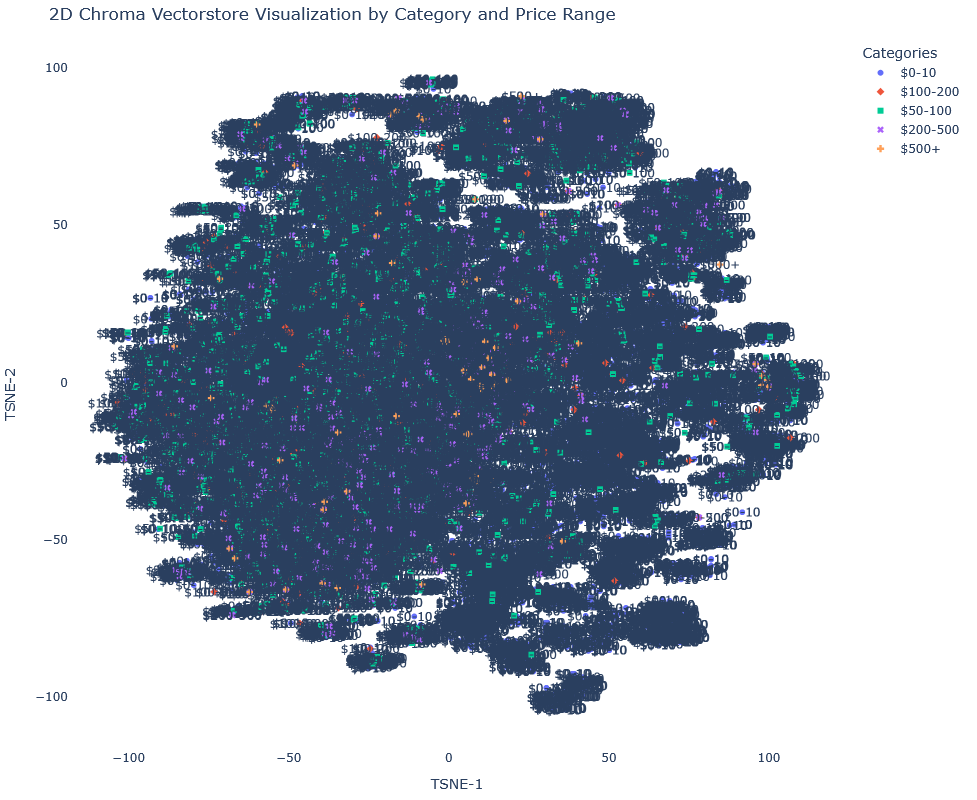

In [70]:
import pandas as pd
import plotly.express as px

df = pd.DataFrame({
    'x': reduced_vectors[:, 0],
    'y': reduced_vectors[:, 1],
    'Price': prices,
    'Price_Bin': price_bins,
    'hover_text': hover_texts
})

df['x'] = reduced_vectors[:, 0]
df['y'] = reduced_vectors[:, 1]

# Create the scatter plot with both category and price bin information
fig = px.scatter(
    df, 
    x='x', 
    y='y',
    color='Price_Bin',  # Color by category
    symbol='Price_Bin',  # Symbol by price bin
    hover_data=['Price'],  # Show price in hover
    text='Price_Bin',  # Optional: show price bin as text
    title='2D Chroma Vectorstore Visualization by Category and Price Range',
    labels={'x': 'TSNE-1', 'y': 'TSNE-2'},
    height=800,
    width=1200
)

# Customize the figure
fig.update_traces(
    marker=dict(size=10, opacity=0.7, line=dict(width=1, color='DarkSlateGrey')),
    selector=dict(mode='markers')
)

# Update layout for better readability
fig.update_layout(
    legend_title_text='Categories',
    font=dict(size=12),
    plot_bgcolor='white',
    margin=dict(r=20, b=10, l=10, t=40)
)

# Show the plot
fig.show()

# Random Forest

In [20]:
from sklearn.model_selection import RandomizedSearchCV
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [76]:
param_dist = {
    'n_estimators': [10, 20, 50, 100],  
    'max_depth': [None, 10, 20, 30],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

base_rf = RandomForestRegressor(random_state=42)

rf_random = RandomizedSearchCV(
    estimator=base_rf,
    param_distributions=param_dist,
    n_iter=20,  
    cv=5,       
    verbose=2,
    random_state=42,
    n_jobs=-1   
)

start_time = time.time()
print("Starting RandomizedSearchCV fitting...")

rf_random.fit(vectors, prices)

execution_time = time.time() - start_time
print(f"RandomizedSearchCV completed in {execution_time:.2f} seconds")

print("Best parameters found:")
print(rf_random.best_params_)

Starting RandomizedSearchCV fitting...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
RandomizedSearchCV completed in 4960.90 seconds
Best parameters found:
{'n_estimators': 100, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None}


In [3]:
# Save the model to a file
import joblib

joblib.dump(rf_random, 'random_forest_model.pkl')

NameError: name 'rf_random' is not defined

In [30]:
rf_model = joblib.load('random_forest_model.pkl')
rf_model

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'n_estimators': [10, 20, 50, 100]},
                   random_state=42, verbose=2)

# Tester GPT & Random Forest

In [18]:
from agents.frontier_agent import FrontierAgent
from agents.random_forest_agent import RandomForestAgent

In [38]:
frontier = FrontierAgent(collection)
random_forest = RandomForestAgent()

In [19]:
def description(item):
    return item.prompt.split("to the nearest dollar?\n\n")[1].split("\n\nPrice is $")[0]
    
def rf(item):
    return random_forest.price(description(item))

def gpt(item):
    return frontier.price(description(item))

1: Guess: $51.97 Truth: $8.98 Error: $42.99 SLE: 2.79 Item: Horror Double Feature (Night Train to Te...
2: Guess: $50.24 Truth: $5.99 Error: $44.25 SLE: 3.97 Item: F1 Chequered Flag [Download]
3: Guess: $31.14 Truth: $19.29 Error: $11.85 SLE: 0.21 Item: HORI Nintendo Switch Premium Vault Case ...
4: Guess: $52.17 Truth: $32.90 Error: $19.27 SLE: 0.20 Item: CORSAIR M65 ELITE RGB - FPS Gaming Mouse...
5: Guess: $34.05 Truth: $4.99 Error: $29.06 SLE: 3.12 Item: Crusader Kings II: Legacy of Rome [Onlin...
6: Guess: $47.85 Truth: $6.99 Error: $40.86 SLE: 3.28 Item: Microsoft Xbox 360 Chatpad "Genuine Orig...
7: Guess: $34.51 Truth: $29.99 Error: $4.52 SLE: 0.02 Item: Animal Crossing: New Leaf
8: Guess: $99.39 Truth: $169.99 Error: $70.60 SLE: 0.28 Item: Kinhank Super Console Arcade Game Consol...
9: Guess: $49.23 Truth: $33.33 Error: $15.90 SLE: 0.14 Item: The Original Universal Illuminated RGB V...
10: Guess: $32.88 Truth: $22.98 Error: $9.90 SLE: 0.12 Item: DVD ROM Disc Repair Replacement

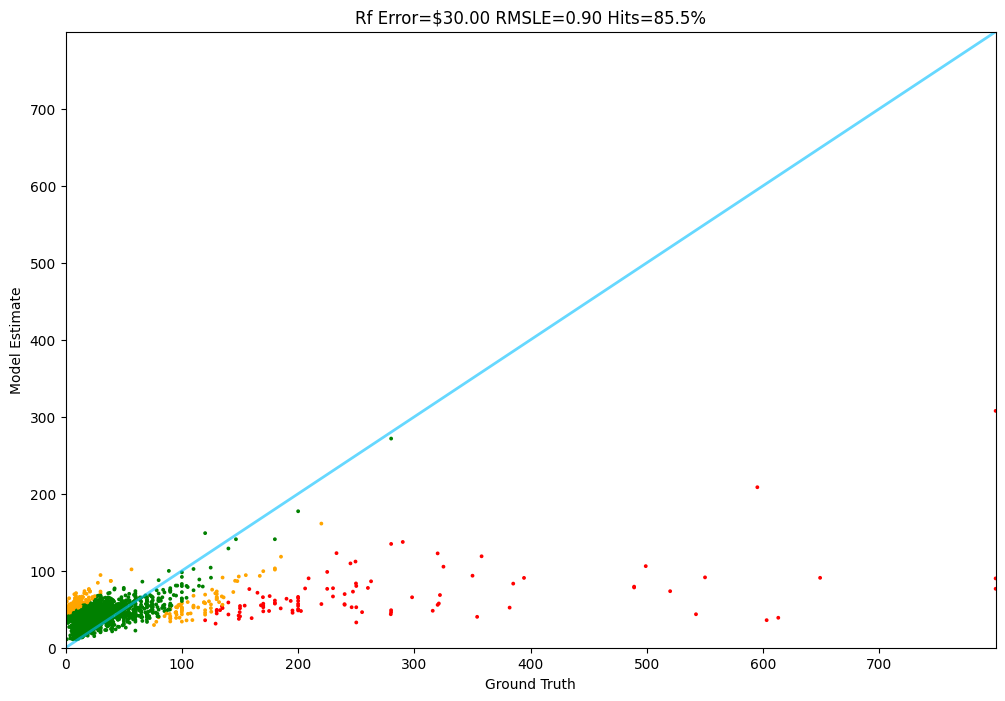

In [47]:
from testing import Tester

tester = Tester(rf, test, size=len(test))
tester.run()

1: Guess: $14.99 Truth: $8.98 Error: $6.01 SLE: 0.22 Item: Horror Double Feature (Night Train to Te...
2: Guess: $30.00 Truth: $5.99 Error: $24.01 SLE: 2.22 Item: F1 Chequered Flag [Download]
3: Guess: $24.99 Truth: $19.29 Error: $5.70 SLE: 0.06 Item: HORI Nintendo Switch Premium Vault Case ...
4: Guess: $44.99 Truth: $32.90 Error: $12.09 SLE: 0.09 Item: CORSAIR M65 ELITE RGB - FPS Gaming Mouse...
5: Guess: $9.99 Truth: $4.99 Error: $5.00 SLE: 0.37 Item: Crusader Kings II: Legacy of Rome [Onlin...
6: Guess: $14.99 Truth: $6.99 Error: $8.00 SLE: 0.48 Item: Microsoft Xbox 360 Chatpad "Genuine Orig...
7: Guess: $29.99 Truth: $29.99 Error: $0.00 SLE: 0.00 Item: Animal Crossing: New Leaf
8: Guess: $159.99 Truth: $169.99 Error: $10.00 SLE: 0.00 Item: Kinhank Super Console Arcade Game Consol...
9: Guess: $45.99 Truth: $33.33 Error: $12.66 SLE: 0.10 Item: The Original Universal Illuminated RGB V...
10: Guess: $25.99 Truth: $22.98 Error: $3.01 SLE: 0.01 Item: DVD ROM Disc Repair Replacement Dri

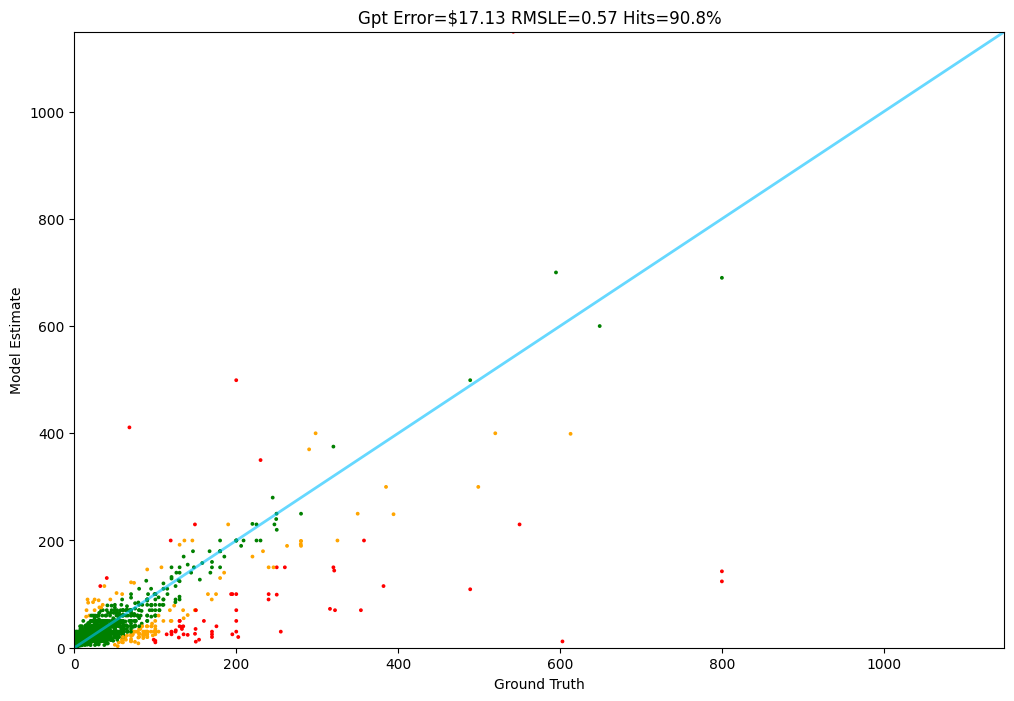

INFO:backoff:Backing off send_request(...) for 1.0s (requests.exceptions.ReadTimeout: HTTPSConnectionPool(host='us.i.posthog.com', port=443): Read timed out. (read timeout=15))


In [57]:
tester = Tester(gpt, test, size=len(test))
tester.run()

# Ensemble Model

In [60]:
frontiers = []
random_forests = []
prices = []
for item in tqdm(test):
    text = description(item)
    frontiers.append(frontier.price(text))
    random_forests.append(random_forest.price(text))
    prices.append(item.price)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [32:04<00:00,  1.04it/s]


In [106]:
import pandas as pd

mins = [min(f,r) for f,r in zip(frontiers, random_forests)]
maxes = [max(f,r) for f,r in zip(frontiers, random_forests)]

X = pd.DataFrame({
    'Frontier': frontiers,
    'RandomForest': random_forests,
    'Min': mins,
    'Max': maxes,
})

# Convert y to a Series
y = pd.Series(prices)

In [107]:
X

Frontier  RandomForest    Min        Max
0        14.99     51.966482  14.99  51.966482
1        30.00     50.240133  30.00  50.240133
2        24.99     31.139735  24.99  31.139735
3        44.99     52.169220  44.99  52.169220
4         9.99     34.050330   9.99  34.050330
...        ...           ...    ...        ...
1995     25.00     31.546925  25.00  31.546925
1996     28.50     53.401951  28.50  53.401951
1997     24.99     49.820606  24.99  49.820606
1998     24.99     30.477232  24.99  30.477232
1999     19.00     34.026948  19.00  34.026948

[2000 rows x 4 columns]

In [108]:
from sklearn.linear_model import LinearRegression

# Train a Linear Regression
np.random.seed(42)

lr = LinearRegression()
lr.fit(X, y)

feature_columns = X.columns.tolist()

for feature, coef in zip(feature_columns, lr.coef_):
    print(f"{feature}: {coef:.2f}")
print(f"Intercept={lr.intercept_:.2f}")

Frontier: 0.60
RandomForest: 0.17
Min: 0.65
Max: 0.12
Intercept=-11.92


In [116]:
X.columns

Index(['Frontier', 'RandomForest', 'Min', 'Max'], dtype='object')

In [110]:
joblib.dump(lr, 'ensemble_model.pkl')

['ensemble_model.pkl']

# Tester Ensemble Model

In [21]:
from agents.ensemble_agent import EnsembleAgent
ensemble = EnsembleAgent(collection)

In [22]:
def ensemble_pricer(item):
    return ensemble.price(description(item))

In [23]:
product = test[0].prompt

In [24]:
ensemble.price(product)

10.138390433517841

1: Guess: $22.30 Truth: $8.98 Error: $13.32 SLE: 0.72 Item: Horror Double Feature (Night Train to Te...
2: Guess: $40.45 Truth: $5.99 Error: $34.46 SLE: 3.17 Item: F1 Chequered Flag [Download]
3: Guess: $28.50 Truth: $19.29 Error: $9.21 SLE: 0.14 Item: HORI Nintendo Switch Premium Vault Case ...
4: Guess: $59.68 Truth: $32.90 Error: $26.78 SLE: 0.34 Item: CORSAIR M65 ELITE RGB - FPS Gaming Mouse...
5: Guess: $10.71 Truth: $4.99 Error: $5.72 SLE: 0.45 Item: Crusader Kings II: Legacy of Rome [Onlin...
6: Guess: $21.06 Truth: $6.99 Error: $14.07 SLE: 1.03 Item: Microsoft Xbox 360 Chatpad "Genuine Orig...
7: Guess: $35.73 Truth: $29.99 Error: $5.74 SLE: 0.03 Item: Animal Crossing: New Leaf
8: Guess: $185.28 Truth: $169.99 Error: $15.29 SLE: 0.01 Item: Kinhank Super Console Arcade Game Consol...
9: Guess: $60.05 Truth: $33.33 Error: $26.72 SLE: 0.33 Item: The Original Universal Illuminated RGB V...
10: Guess: $30.26 Truth: $22.98 Error: $7.28 SLE: 0.07 Item: DVD ROM Disc Repair Replacement 

INFO:backoff:Backing off send_request(...) for 0.9s (requests.exceptions.ReadTimeout: HTTPSConnectionPool(host='us.i.posthog.com', port=443): Read timed out. (read timeout=15))


1018: Guess: $27.63 Truth: $19.99 Error: $7.64 SLE: 0.10 Item: Gothic Universe Edition [Online Game Cod...
1019: Guess: $242.38 Truth: $394.28 Error: $151.90 SLE: 0.24 Item: Next Level Racing Elite Freestanding Sin...
1020: Guess: $59.06 Truth: $50.56 Error: $8.50 SLE: 0.02 Item: Ashes Cricket (PS4)
1021: Guess: $35.16 Truth: $34.00 Error: $1.16 SLE: 0.00 Item: uDraw GameTablet with uDraw Studio - Nin...
1022: Guess: $18.63 Truth: $14.99 Error: $3.64 SLE: 0.04 Item: Charging Dock for Xbox Elite Wireless Co...
1023: Guess: $25.09 Truth: $7.99 Error: $17.10 SLE: 1.13 Item: Elements of Destruction - PC
1024: Guess: $76.30 Truth: $68.53 Error: $7.77 SLE: 0.01 Item: Dead Island 2: Day 1 Edition - PlayStati...
1025: Guess: $28.02 Truth: $29.99 Error: $1.97 SLE: 0.00 Item: HEYSTOP Carry Case Compatible with Ninte...
1026: Guess: $10.49 Truth: $9.99 Error: $0.50 SLE: 0.00 Item: Angela Young's Dream Adventure [Download...
1027: Guess: $20.91 Truth: $14.99 Error: $5.92 SLE: 0.10 Item: Xia-Xia - 

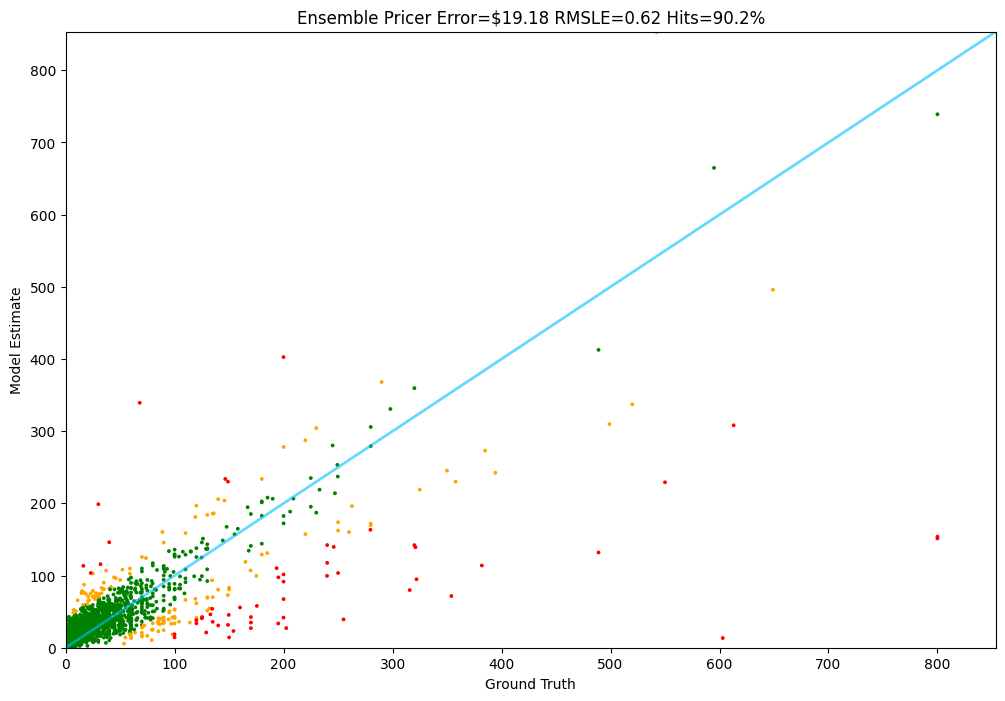

INFO:backoff:Backing off send_request(...) for 1.0s (requests.exceptions.ReadTimeout: HTTPSConnectionPool(host='us.i.posthog.com', port=443): Read timed out. (read timeout=15))


In [25]:
tester = Tester(ensemble_pricer, test, size=len(test))
tester.run()